[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/STMicroelectronics/stm32ai/blob/master/AI_resources/HAR/Human_Activity_Recognition.ipynb)

# Human Activity Recognition

This notebook shows the process of creating a basic motion sensing activity classifier model, using Keras, for STM32 embedded applications.


In [1]:
import tensorflow as tf
print(tf.version.VERSION)

2.18.0


In [2]:
!wget -nc https://github.com/STMicroelectronics/stm32ai/raw/master/AI_resources/HAR/dataset.zip
!unzip -n dataset.zip

File ‘dataset.zip’ already there; not retrieving.

Archive:  dataset.zip


# download model

In [3]:
!wget -nc https://github.com/STMicroelectronics/stm32ai/raw/master/AI_resources/HAR/model.h5

File ‘model.h5’ already there; not retrieving.



In [4]:
import glob
import numpy as np

# Load data into memory
labels = ['stationary', 'walking', 'running']
x_recordings = []
y_recordings = []
recordings_filenames = []
for i, label in enumerate(labels):
    filenames = glob.glob('dataset/' + label + '/*.csv')
    for filename in filenames:
        data = np.loadtxt(filename, delimiter=',')
        x_recordings.append(data)
        y_recordings.append(i)
        recordings_filenames.append(filename)

x_recordings = np.array(x_recordings).reshape(len(x_recordings), -1, 3)
y_recordings = np.array(y_recordings)

print(x_recordings.shape)
print(y_recordings.shape)

(92, 1000, 3)
(92,)


# Exploring the dataset

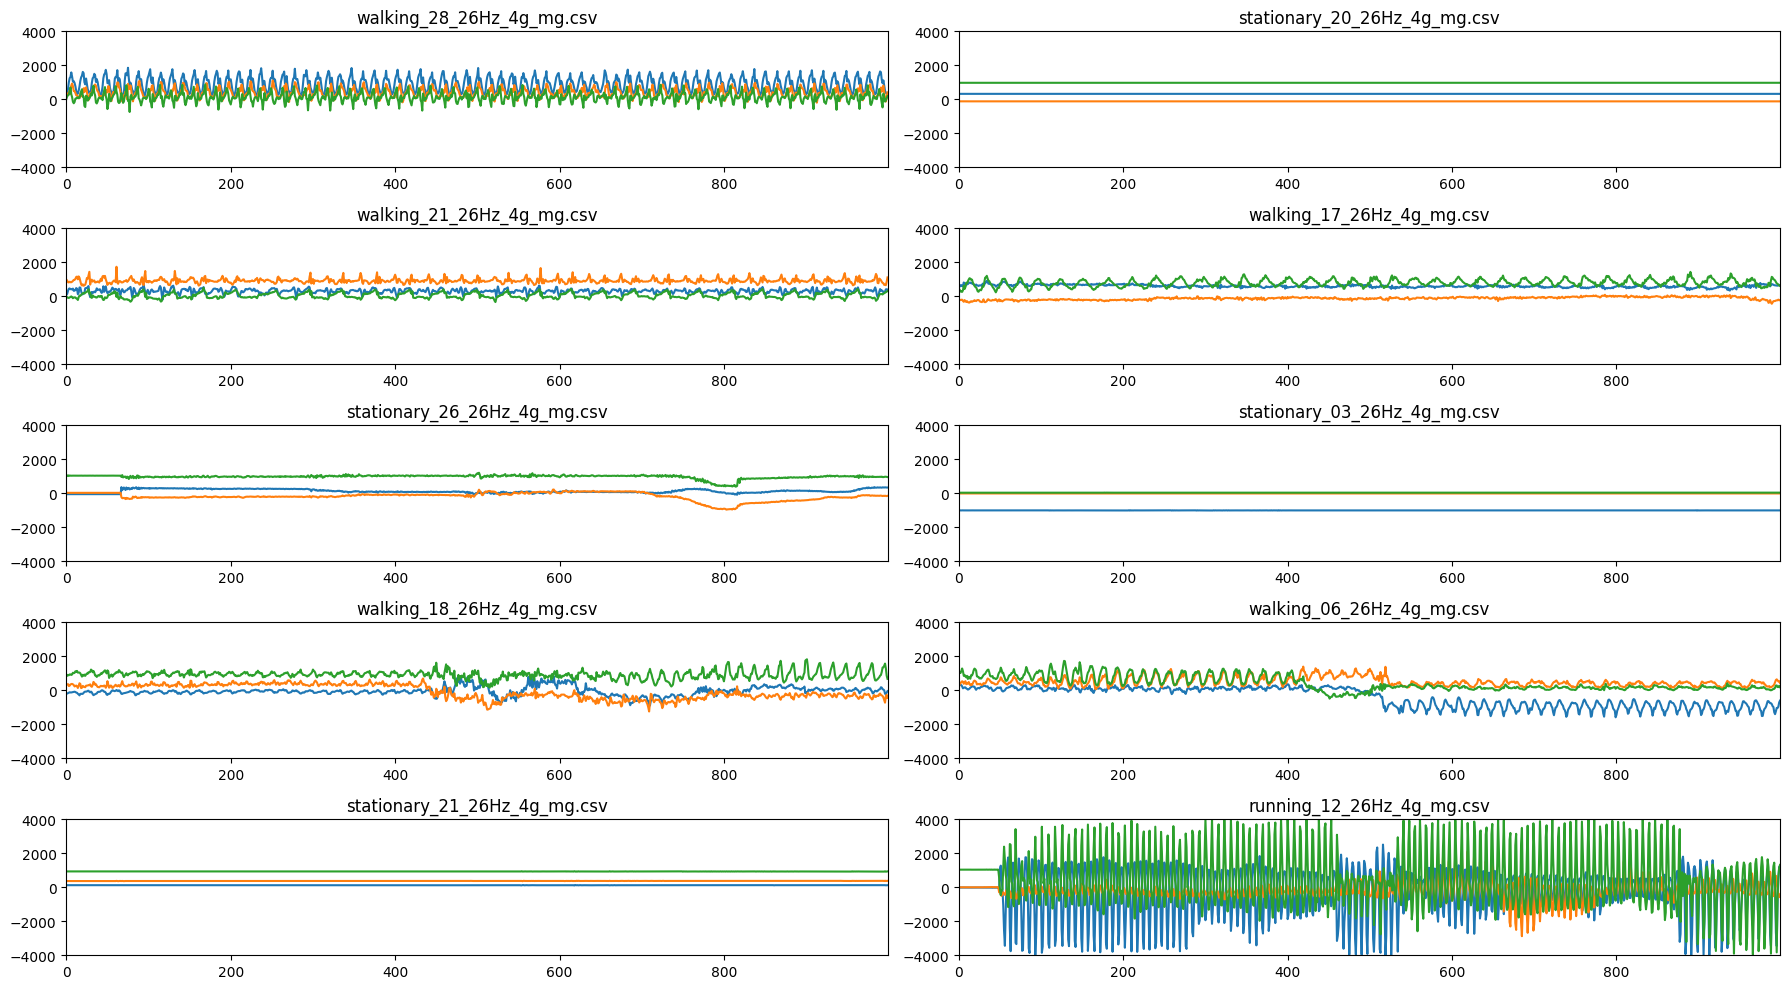

In [5]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Plot some captures
random.seed(10)
unique_rands = random.sample(range(len(x_recordings)), 10)
plt.figure(figsize=(18, 10))
for i, n in enumerate(unique_rands):
    plt.subplot(5, 2, i + 1)
    plt.margins(x=0, y=-0.25)
    plt.plot(x_recordings[n])
    plt.ylim(-4000, 4000)  # 4000 mg acc. range
    plt.title(recordings_filenames[n].split('/')[-1])
plt.tight_layout()
plt.show()

In [6]:
import numpy as np

def frame(x, frame_len, hop_len):
    '''Slice a 3D data array into (overlapping) frames.

    Example
    --------
    >>> x = np.array([[0, 1, 2],
                      [10, 11, 12],
                      [20, 21, 22],
                      [30, 31, 32],
                      [40, 41, 42],
                      [50, 51, 52],
                      [60, 61, 62]])
    >>> frames = x.frame(x, 3, 2)
    >>> x.shape
    (7, 3)
    >>> frames.shape
    (3, 3, 3)
    '''

    assert(x.shape == (len(x), 3))
    assert(x.shape[0] >= frame_len)
    assert(hop_len >= 1)

    n_frames = 1 + (x.shape[0] - frame_len) // hop_len
    shape = (n_frames, frame_len, x.shape[1])
    strides = ((hop_len * x.strides[0],) + x.strides)
    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

x_frames = []
y_frames = []
for i in range(x_recordings.shape[0]):
    # frames = frame(x_recordings[i], 26, 26) # no overlap
    frames = frame(x_recordings[i], 26, 13) # 50% overlap
    x_frames.append(frames)
    y_frames.append(np.full(frames.shape[0], y_recordings[i]))

print(np.array(x_frames).shape)
x_frames = np.concatenate(x_frames)
y_frames = np.concatenate(y_frames)
print(x_frames.shape)

# Each output label is an integer between 0 and 2:
print(y_frames.shape)
print(labels)

(92, 75, 26, 3)
(6900, 26, 3)
(6900,)
['stationary', 'walking', 'running']


In [13]:
print(y_frames.shape)
for i, y in enumerate(y_frames):
  print(i, y)

(6900,)
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
154 0
155 0
156 0
157 0
158 0
159 0
160 0
161 0
162 0
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 0
171 0
172 0
173 0
174 0
175 0
176 0
177 0
178 0
179 0
180 0
181 0
182 0
183 

In [7]:
# Normalize input data between [-1;1]
x_frames_normed = x_frames / 4000

# Load pre-trained model

In [8]:
model = tf.keras.models.load_model('model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


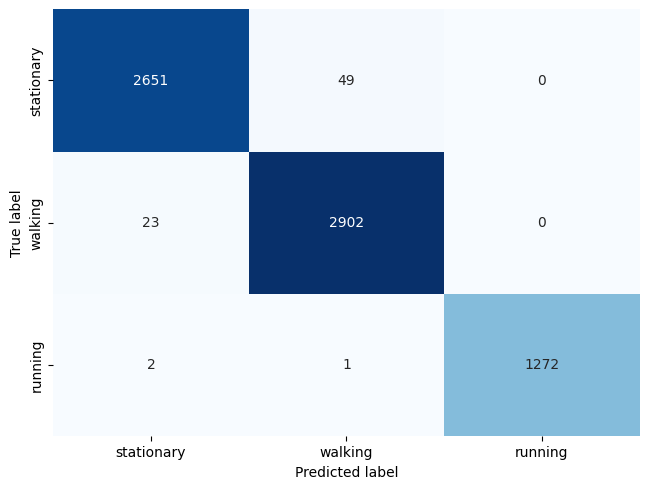

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Y_pred = model.predict(x_frames_normed)
y_pred = np.argmax(Y_pred, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_frames, y_pred)

plt.figure()
sns.heatmap(confusion_matrix,
            annot=True,
            xticklabels=labels,
            yticklabels=labels,
            cmap=plt.cm.Blues,
            fmt='d', cbar=False)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [16]:
for i, y in enumerate(Y_pred):
  print(i, y)

Streaming output truncated to the last 5000 lines.
1900 [0.         0.         0.99999994]
1901 [0.         0.         0.99999994]
1902 [0.         0.         0.99999994]
1903 [0.         0.         0.99999994]
1904 [0.         0.         0.99999994]
1905 [0.         0.         0.99999994]
1906 [0.         0.         0.99999994]
1907 [0.         0.         0.99999994]
1908 [0.         0.         0.99999994]
1909 [0.         0.         0.99999994]
1910 [0.         0.         0.99999994]
1911 [0.         0.         0.99999994]
1912 [0.         0.         0.99999994]
1913 [0.         0.         0.99999994]
1914 [0.         0.         0.99999994]
1915 [0.         0.         0.99999994]
1916 [0.         0.         0.99999994]
1917 [0.         0.         0.99999994]
1918 [0.         0.         0.99999994]
1919 [0.         0.         0.99999994]
1920 [0.         0.         0.99999994]
1921 [0.         0.         0.99999994]
1922 [0.         0.         0.99999994]
1923 [0.         0.         0